# Table of Contents

1. [Business Understanding](#Business-Understanding)
2. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
3. [Data Preprocessing](#Data-Preprocessing)
4. [Model Building](#Model-Building)
5. [Productivization Plan](#Productivization-Plan)

In [128]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from category_encoders import OrdinalEncoder, LeaveOneOutEncoder

from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.ensemble import StackingClassifier

# from tensorflow import keras
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import log_loss, accuracy_score, roc_auc_score, make_scorer

import pickle


random_state = np.random.RandomState(1)
np.random.seed(1) # for reproducibility

# Business Understanding
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

Given a set of features, we are asked to <b>predict whether or not a given household is poor or not</b>. This is a <b>binary classification</b>, which specifically posits the following problem: what is the <b>probability</b> of a given household of being poor. This probability is actually the prediction value and the loss function measures the prediction performance. For a binary classification, the typical loss function is the binary cross-entropy or <b>log loss</b>.<br>

Log Loss is a slight twist on the Likelihood Function. In fact, Log Loss is -1 * the log of the likelihood function. The likelihood function answers the question "how likely did the model think the actually observed set of outcomes was" and is computed iteratively stepping through all predictions by multiplying the probability associated with the actual outcome and subsequently by the previous result.<br>

Predictions range between 0 and 1, and their resulting multiplication gets so small that computers can't keep track of it. So, as a clever computational trick, we instead keep track of the log of the Likelihood. We multiply this by negative 1 to maintain a common convention that lower loss scores are better. Lower loss scores are associated with higher probabilities and viceversa<br>

Since data is anonimized and no context information has been provided, no economic analysis on variables is possible. Let's now have some insights on the data.

# Exploratory Data Analysis
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

## Load Data

In [2]:
# Train dataset
data_train = pd.read_csv('../data/Exercise_train (1).csv', sep=',')
data_train.head()

,Unnamed: 0,id,kjkrfgld,bpowgknt,raksnhjf,vwpsxrgk,omtioxzz,yfmzwkru,tiwrsloh,weioazcf,poor
0,2225,29252,KfoTG,zPfZR,DtMvg,NaN,12.0,-3.0,-1.0,0.5,False
1,1598,98286,ljBjd,THHLT,DtMvg,esAQH,21.0,-2.0,-5.0,-9.5,True
2,7896,49040,Lsuai,zPfZR,zeYAm,ZCIYy,12.0,-3.0,-5.0,-9.5,True
3,1458,35261,KfoTG,mDadf,zeYAm,ZCIYy,12.0,-1.0,-5.0,-9.5,False
4,1817,98833,KfoTG,THHLT,DtMvg,ARuYG,21.0,-4.0,-5.0,-9.5,True


In [3]:
# Test dataset
data_test = pd.read_csv('../data/Exercise_test (1).csv', sep=',')
data_test.head()

,Unnamed: 0,id,kjkrfgld,bpowgknt,raksnhjf,vwpsxrgk,omtioxzz,yfmzwkru,tiwrsloh,weioazcf,poor
0,2197,42706,qzGkS,zPfZR,rXCdD,IJnCs,21.0,-3.0,-5.0,-9.5,False
1,4823,65531,KfoTG,THHLT,DtMvg,XHmQd,21.0,-2.0,-9.0,-19.5,True
2,4165,64452,tnDpM,THHLT,qTmDg,yygvO,30.0,-4.0,-9.0,-19.5,True
3,4962,78022,NaN,WXYiE,DtMvg,XAmOF,21.0,-2.0,3.0,10.5,False
4,4671,45674,Lsuai,zPfZR,DtMvg,hmAUm,30.0,-4.0,-5.0,-9.5,True


In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6562 entries, 0 to 6561
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  6562 non-null   int64  
 1   id          6562 non-null   int64  
 2   kjkrfgld    6366 non-null   object 
 3   bpowgknt    6357 non-null   object 
 4   raksnhjf    6381 non-null   object 
 5   vwpsxrgk    6364 non-null   object 
 6   omtioxzz    6361 non-null   float64
 7   yfmzwkru    6353 non-null   float64
 8   tiwrsloh    6355 non-null   float64
 9   weioazcf    6366 non-null   float64
 10  poor        6562 non-null   bool   
dtypes: bool(1), float64(4), int64(2), object(4)
memory usage: 519.2+ KB


In [8]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1641 entries, 0 to 1640
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1641 non-null   int64  
 1   id          1641 non-null   int64  
 2   kjkrfgld    1595 non-null   object 
 3   bpowgknt    1592 non-null   object 
 4   raksnhjf    1605 non-null   object 
 5   vwpsxrgk    1596 non-null   object 
 6   omtioxzz    1587 non-null   float64
 7   yfmzwkru    1597 non-null   float64
 8   tiwrsloh    1601 non-null   float64
 9   weioazcf    1579 non-null   float64
 10  poor        1641 non-null   bool   
dtypes: bool(1), float64(4), int64(2), object(4)
memory usage: 129.9+ KB


In both datasets, we encounter:
<ul>
    <li> same number of non-null values in the columns Unnamed: 0 (supposedly, individuals <code>iid</code>) and households <code>id</code>, so that individuals analysis (or the size of a household) becomes irrelevant</li>
    <li> four possible categorical (nominal) variables represented as object (strings) with missing values both in train and in test (3% of each dataset approximately)</li>
    <li> four continuous variables represented as float, with missing values both in train and in test (3% of each dataset approximately)</li>
    <li> target variable represented as a boolean</li>
</ul>

#### No duplicates / Unique observations

In [17]:
column_names = [x for x in data_train.columns]
duplicates = data_train.duplicated(subset=column_names, keep=False)
data_train[duplicates]

,Unnamed: 0,id,kjkrfgld,bpowgknt,raksnhjf,vwpsxrgk,omtioxzz,yfmzwkru,tiwrsloh,weioazcf,poor


In [7]:
data_train.id.nunique() 

6562

In [9]:
column_names = [x for x in data_test.columns]
duplicates = data_test.duplicated(subset=column_names, keep=False)
data_test[duplicates]

,Unnamed: 0,id,kjkrfgld,bpowgknt,raksnhjf,vwpsxrgk,omtioxzz,yfmzwkru,tiwrsloh,weioazcf,poor


In [8]:
data_test.id.nunique()

1641

We now set the DataFrame's index to household's <code>id</code> for further analysis.

In [30]:
data_train = data_train.set_index('id')
data_test = data_test.set_index('id')

## Target

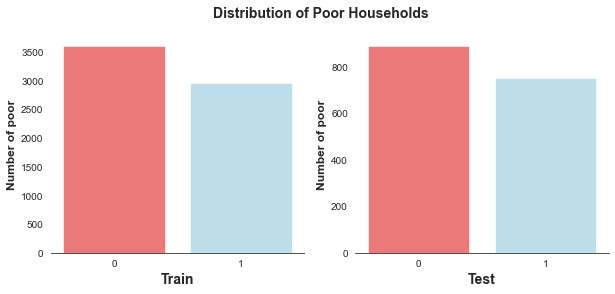

In [27]:
sns.set_style('white')
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

# Create a countplot
sns.countplot(x='poor',
              data=data_train,
              order=[0, 1],
              # Set colour of hue and transperency
              palette = ["r","skyblue"],
              alpha = 0.6,
              ax=axes[0])

# Final styling touche
axes[0].set_ylabel("Number of poor", fontsize = 12, fontweight = "semibold")
axes[0].set_xlabel("Train", fontweight = "semibold", fontsize = 14)


# Create a countplot
sns.countplot(x='poor',
              data=data_test,
              order=[0, 1],
              # Set colour of hue and transperency
              palette = ["r","skyblue"],
              alpha = 0.6,
              ax=axes[1])

# Final styling touche
axes[1].set_ylabel("Number of poor", fontsize = 12, fontweight = "semibold")
axes[1].set_xlabel("Test", fontweight = "semibold", fontsize = 14)

# Despine visualizations
sns.despine(left=True)
fig.suptitle("Distribution of Poor Households", fontweight = "semibold", fontsize = 14)
plt.show()

## Numerical features

In [26]:
data_train.describe()

,Unnamed: 0,omtioxzz,yfmzwkru,tiwrsloh,weioazcf
count,6562.000000,6361.000000,6353.000000,6355.000000,6366.000000
mean,4113.757543,17.455117,-2.826696,-4.194335,-7.461828
std,2353.382080,10.924393,12.615775,4.476410,11.198626
min,0.000000,-127.000000,-4.000000,-31.000000,-74.500000
25%,2088.500000,12.000000,-4.000000,-7.000000,-14.500000
50%,4115.500000,12.000000,-3.000000,-3.000000,-4.500000
75%,6156.750000,21.000000,-2.000000,-1.000000,0.500000
max,8202.000000,111.000000,1000.000000,3.000000,10.500000


Text(0.5, 0, 'omtioxzz')

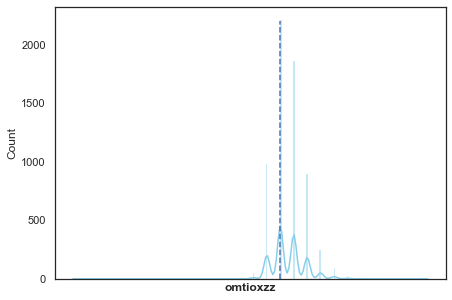

In [112]:
# Create plot of omtioxzz distribution
sns.set_style('white')
plt.figure(figsize=(7,5))
sns.histplot(data=data_train,
             x='omtioxzz',
             color = "skyblue",
             kde = True)

# Add vertical line and annotate median age for male employees
plt.axvline(data_train['omtioxzz'].median(), ymax = 0.95, linestyle = "--")
# Format subplot in axes
plt.xticks([])
plt.xlabel("omtioxzz", fontsize = 12, fontweight = "semibold")

Text(0.5, 0, 'yfmzwkru')

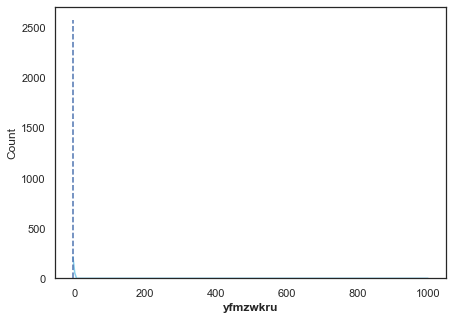

In [115]:
# Create plot of omtioxzz distribution
sns.set_style('white')
plt.figure(figsize=(7,5))
sns.histplot(data=data_train,
             x='yfmzwkru',
             color = "skyblue",
             kde = True,
             hue_norm=[-5, 100])

# Add vertical line and annotate median age for male employees
plt.axvline(data_train['yfmzwkru'].median(), ymax = 0.95, linestyle = "--")
# Format subplot in axes
#plt.xticks([])
plt.xlabel("yfmzwkru", fontsize = 12, fontweight = "semibold")

Text(0.5, 0, 'tiwrsloh')

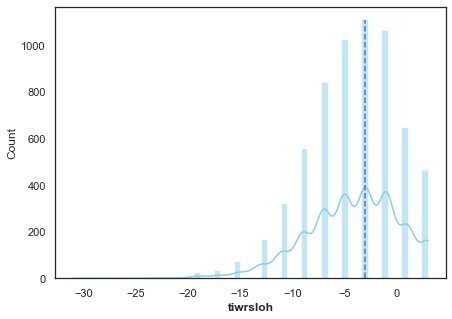

In [119]:
# Create plot of omtioxzz distribution
sns.set_style('white')
plt.figure(figsize=(7,5))
sns.histplot(data=data_train,
             x='tiwrsloh',
             color = "skyblue",
             kde = True)

# Add vertical line and annotate median age for male employees
plt.axvline(data_train['tiwrsloh'].median(), ymax = 0.95, linestyle = "--")
# Format subplot in axes
#plt.xticks([])
plt.xlabel("tiwrsloh", fontsize = 12, fontweight = "semibold")

Text(0.5, 0, 'weioazcf')

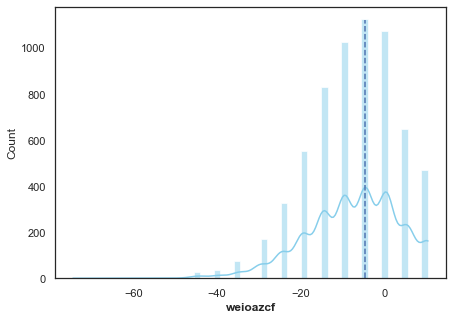

In [118]:
# Create plot of omtioxzz distribution
sns.set_style('white')
plt.figure(figsize=(7,5))
sns.histplot(data=data_train,
             x='weioazcf',
             color = "skyblue",
             kde = True)

# Add vertical line and annotate median age for male employees
plt.axvline(data_train['weioazcf'].median(), ymax = 0.95, linestyle = "--")
# Format subplot in axes
#plt.xticks([])
plt.xlabel("weioazcf", fontsize = 12, fontweight = "semibold")

AttributeError: 'numpy.ndarray' object has no attribute 'xaxis'

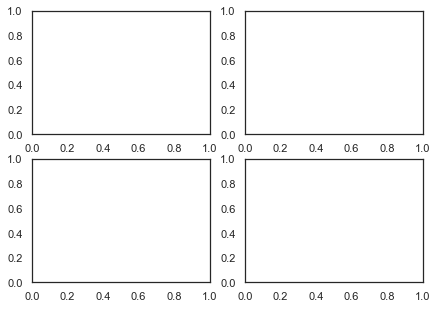

In [120]:
# Set initial plot options
sns.set_style('white')

# Create figure and axes
fig, axes = plt.subplots(2, 2, figsize=(7, 5))

# Create plot of omtioxzz distribution on first axes
sns.histplot(data=data_train,
             x='omtioxzz',
             color = "skyblue",
             kde = True,
             ax=axes[0])

# Add vertical line and annotate median age for male employees on first axes
axes[0].axvline(data_train['omtioxzz'].median(), ymax = 0.95, linestyle = "--")
# Format subplot in axes
# axes[0].set_yticks([])
axes[0].set_xlabel("omtioxzz", fontsize = 12, fontweight = "semibold")


# Create plot of yfmzwkru distribution on second axes
sns.histplot(data=data_train,
             x='yfmzwkru',
             color = "skyblue",
             kde = True,
             ax=axes[1])

# Add vertical line and annotate median age for male employees on first axes
axes[1].axvline(data_train['yfmzwkru'].median(), ymax = 0.95, linestyle = "--")
# Format subplot in axes
# axes[0].set_yticks([])
axes[1].set_xlabel("yfmzwkru", fontsize = 12, fontweight = "semibold")


# Create plot of tiwrsloh distribution on third axes
sns.histplot(data=data_train,
             x='tiwrsloh',
             color = "skyblue",
             kde = True,
             ax=axes[2])

# Add vertical line and annotate median age for male employees on first axes
axes[2].axvline(data_train['tiwrsloh'].median(), ymax = 0.95, linestyle = "--")
# Format subplot in axes
# axes[0].set_yticks([])
axes[2].set_xlabel("tiwrsloh", fontsize = 12, fontweight = "semibold")


# Create plot of weioazcf distribution on third axes
sns.histplot(data=data_train,
             x='weioazcf',
             color = "skyblue",
             kde = True,
             ax=axes[3])

# Add vertical line and annotate median age for male employees on first axes
axes[3].axvline(data_train['weioazcf'].median(), ymax = 0.95, linestyle = "--")
# Format subplot in axes
# axes[0].set_yticks([])
axes[3].set_xlabel("weioazcf", fontsize = 12, fontweight = "semibold")


# Despine visualizations
sns.despine(left = True)
# Figure final formatting   
fig.suptitle('Numerical Variables Distribution', fontsize = 14, fontweight = "semibold")
plt.show()

Descriptive statistics of the four numerical variables uncover the following:
<ul>
    <li>skewed distributions,</li>
    <li>fat tails and presence of outliers</li>
</ul>

## Categorical features

### Low dimensional categorical variables

AttributeError: 'numpy.ndarray' object has no attribute 'bar'

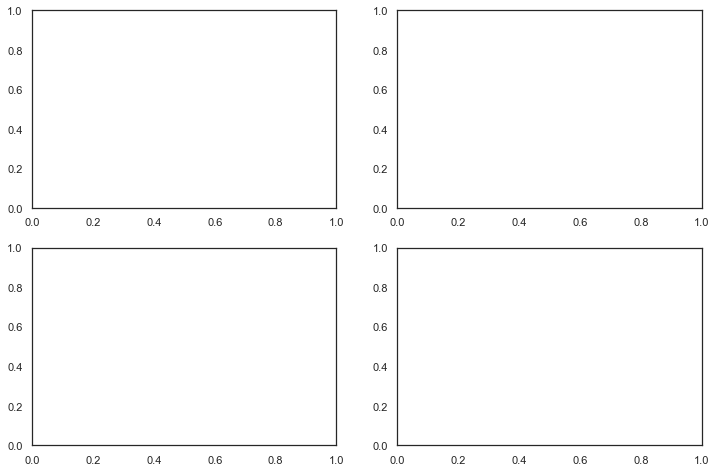

In [88]:
sns.set_style('white')

fig, axes = plt.subplots(2, 2, figsize = (12, 8))


# kjkrfgld_counts = data_train['kjkrfgld'].value_counts()
sns.countplot(x='kjkrfgld', data=data_train, alpha=0.6, ax=axes[0])

axes[0].set_ylabel("Number of occurrences", fontsize = 12, fontweight = "semibold")
axes[0].set_xlabel("kjkrfgld", fontweight = "semibold", fontsize = 14)


# bpowgknt_counts = data_train['bpowgknt'].value_counts()
sns.countplot(x='bpowgknt', data=data_train, alpha=0.6, ax=axes[1])

axes[1].set_ylabel("Number of occurrences", fontsize = 12, fontweight = "semibold")
axes[1].set_xlabel("bpowgknt", fontweight = "semibold", fontsize = 14)


# raksnhjf_counts = data_train['raksnhjf'].value_counts()
sns.countplot(x='raksnhjf', data=data_train, alpha=0.6, ax=axes[2])

axes[2].set_ylabel("Number of occurrences", fontsize = 12, fontweight = "semibold")
axes[2].set_xlabel("raksnhjf", fontweight = "semibold", fontsize = 14)



sns.despine(left=True)
fig.suptitle("Low dimensional Categorical Variables", fontweight = "semibold", fontsize = 14)
plt.show()

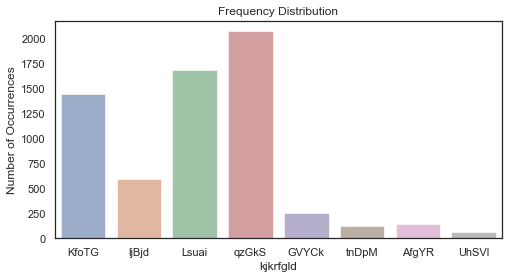

In [92]:
plt.figure(figsize = (8, 4))
sns.set(style="white")
sns.countplot(x='kjkrfgld', data=data_train, alpha=0.6)
plt.title('Frequency Distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('kjkrfgld', fontsize=12)
plt.show()

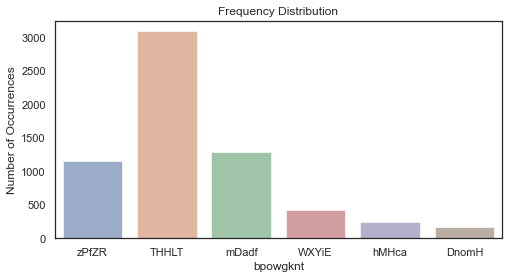

In [93]:
plt.figure(figsize = (8, 4))
sns.set(style="white")
sns.countplot(x='bpowgknt', data=data_train, alpha=0.6)
plt.title('Frequency Distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('bpowgknt', fontsize=12)
plt.show()

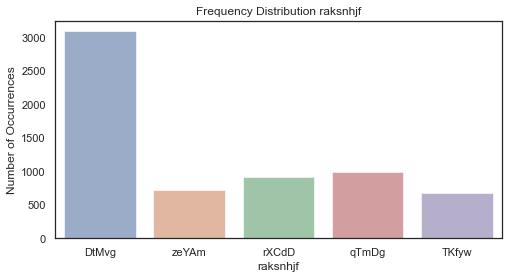

In [94]:
plt.figure(figsize = (8, 4))
sns.set(style="white")
sns.countplot(x='raksnhjf', data=data_train, alpha=0.6)
plt.title('Frequency Distribution raksnhjf')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('raksnhjf', fontsize=12)
plt.show()

### High dimensional categorical variable

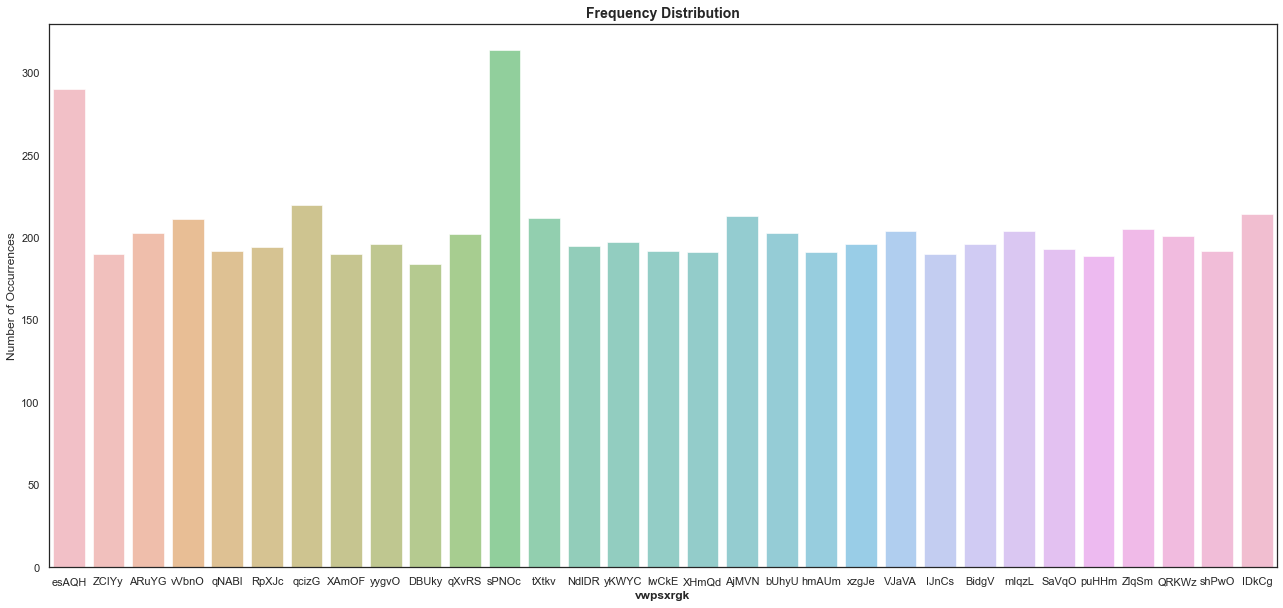

In [97]:
plt.figure(figsize = (22, 10))
sns.set(style="white")

sns.countplot(x='vwpsxrgk', data=data_train, alpha=0.6)

plt.title('Frequency Distribution', fontweight = "bold", fontsize = 14)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('vwpsxrgk', fontsize=12, fontweight = "semibold")
plt.show()

# Data Preprocessing
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

## Target preprocessing

Let's transform our target variable into a binary (0, 1) variable.

In [77]:
data_train['poor'] = data_train['poor'].apply(lambda x: 1 if x == True else 0)

In [78]:
data_test['poor'] = data_test['poor'].apply(lambda x: 1 if x == True else 0)

## Train, Test datasets

In [79]:
X_train = data_train.drop('poor', 1)
y_train = data_train['poor']

In [80]:
X_test = data_test.drop('poor', 1)
y_test = data_test['poor']

## Features preprocessing

In light of the above, some data preprocessing is needed.<br>

As of <b>numerical variables</b>, two steps need to be accomplished:
<ol>
    <li> <b>impute NAs</b> with a median strategy (to better account for non-normal distributions),</li>
    <li> <b>standardize variables</b> aiming at <i>normalize</i> data distributions. We shall use PowerTransformer method, well suited for skewed distributions (and outliers?). Unscaled data can degrade the predictive performance of machine learning algorithms and slow down or even prevent the convergence of many gradient-based estimators.</li>
</ol>
    
[Documentation](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py)
<br>

Regarding <b>categorical variables</b>, any standard work-flow in feature engineering would typically involve some form of transformation of these categorical values into numeric labels and then applying some encoding scheme on these values (see <code>Prepa_Pover-T_Tests.ipynb</code> for a three-step <i>out-of-the-pipe</i> approach). However, in order to streamline the process, we will have recourse to a <i>column transform</i> method instead aiming at <b>simulateneously addressing NAs imputation and variable encoding</b>.<br>


We will opt for an <b>ordinal encoder</b> for those variables with a low dimensionality (and coincidentally, uneven frequency distribution among categories) and for a <b>target encoder</b> for the variable with a greater dimensionality. With target encoding, each category is replaced with the mean target value associated with that category. One of its main benefits is that it prevents the curse of dimensionality; one of its drawbacks is that captures correlations with target values, thus incurring in overfitting. This should be carefully addressed by introducing noise (sigma), as explained in the next section.<br>

For more information, read this [tutorial](https://www.datacamp.com/community/tutorials/categorical-data) and this [post](https://brendanhasz.github.io/2019/03/04/target-encoding).<br>

As such, the <b>preprocessor object</b> arquitecture consists of the following</b>:<br>

<ol>
    <li> <b>Pipeline</b> for NAs imputation and data scaling of <b>numerical features</b></li>
    <li> <b>Column Transformer</b> for variables (numerical and categorical encoding)</li>
</ol>

Check for reference this [video](https://www.youtube.com/watch?v=Ma-CDFLd03g) (1:17 min onwards).

In [81]:
# Categorical features: (i) ordinal encoder for low dimensionality categorical variables (which implicitely impute NAs)
low_dim_cat = ['kjkrfgld', 'bpowgknt', 'raksnhjf']
ordinal_enc = OrdinalEncoder()

# Categorical features (suite): (ii) target encoder for the high dimensionality categorical variable (it also tackles NAs imputation)
high_dim_cat = ['vwpsxrgk']
target_enc = LeaveOneOutEncoder()
    
# Numerical features: (i) impute NAs using median strategy, (ii) scale data using Power Transformer to properly address for skewed distributions and outliers
numeric_features = data_train.select_dtypes(include=['float64']).columns.copy()
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', PowerTransformer())])

# Preprocessor with a Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('ordinal_encoder', ordinal_enc, low_dim_cat),
        ('target_encoder', target_enc, high_dim_cat)])

# Model Building
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

## Baseline model: Logistic Regression

This is the classical function for a binary classification problem. We will use the results of this model as our baseline.

In [56]:
# Logistic Regression
clf = LogisticRegression()
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier',  clf)])

lr = pipe.fit(X_train, y_train)

pipe.predict(X_test)

y_pred = pipe.predict_proba(X_test)
log_loss(y_test, y_pred, eps=1e-15, normalize=True, sample_weight=None, labels=None)


0.5165545774500514

## Random Forest Classifier

The second model to be used is a Random Forest Classifier. It works like this: (i) it selects random samples from a given dataset, (ii) it constructs a decision tree for each sample and gets a prediction result from each decision tree, (iii) it performs a vote for each predicted result, and (iv) it selects the prediction result with the most votes as the final prediction.<br>

We will additionally perform some hyperparameter tuning and cross-validation in order to get the best estimator.<br>

It should be noted that the noise of the target encoder will also be modelled, corresponding to sigma.

In [13]:
clf_rf = RandomForestClassifier()
pipe_rf = Pipeline([('preprocessor', preprocessor), ('classifier',  clf_rf)])

In [14]:
# Hyperparameters can be accessed with a double underscore
param_grid = {
    'preprocessor__target_encoder__sigma': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06],
    'classifier__bootstrap': [True],
    'classifier__max_depth': [80, 90, 100, 110],
    'classifier__max_features': [2, 3],
    'classifier__min_samples_leaf': [3, 4, 5],
#     'classifier__min_samples_split': [8, 10, 12],
    'classifier__n_estimators': [100, 200, 300, 1000]
}

rscv_rf = RandomizedSearchCV(pipe_rf,
                          cv=5,
                          n_iter=5,
                          n_jobs=10,
                          param_distributions = param_grid,
                          scoring='neg_log_loss',
                          random_state=1)


In [68]:
cross_val_score(pipe_rf, X_train, y_train, cv=5, scoring='neg_log_loss')

array([-0.5599944 , -0.57126105, -0.60031365, -0.58997122, -0.60401031])

In [38]:
rf_fit = rscv_rf.fit(X_train, y_train)
rf_fit

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                PowerTransformer())]),
                                                                               Index(['omtioxzz', 'yfmzwkru', 'tiwrsloh', 'weioazcf'], dtype='object')),
                                                                              ('ordinal_encoder',
                                                                               OrdinalEncoder(),
                

In [16]:
rscv_rf.best_params_

{'preprocessor__target_encoder__sigma': 0.02,
 'classifier__n_estimators': 300,
 'classifier__min_samples_leaf': 4,
 'classifier__max_features': 2,
 'classifier__max_depth': 80,
 'classifier__bootstrap': True}

In [17]:
rscv_rf.best_score_

-0.49623545803375035

Metrics [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss)

In [18]:
y_pred_rf = rscv_rf.best_estimator_.predict_proba(X_test)
log_loss(y_test, y_pred_rf, eps=1e-15, normalize=True, sample_weight=None, labels=None)

0.4976755244147369

The scoring metric is slightly improved. 

## Gradient Boosting Methods

[Read](https://machinelearningmastery.com/gradient-boosting-with-scikit-learn-xgboost-lightgbm-and-catboost/) on methods' differences.

### Extreme Gradient Boosting

In [19]:
clf_xgb = XGBClassifier()
pipe_xgb = Pipeline([('preprocessor', preprocessor), ('classifier',  clf_xgb)])

In [20]:
# Hyperparameters can be accessed with a double underscore
param_grid_XGB = {
        'preprocessor__target_encoder__sigma': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06],
        'classifier__n_estimators': [100, 200, 300, 1000],
        'classifier__learning_rate' : [0.01, 0.02, 0.03],
        'classifier__max_depth' : [3, 4, 5],
#         'classifier__objective' : 'binary:logistic',
#         'classifier__silent' : True,
#         'classifier__gamma' : 0.3,
#         'classifier__subsample' : 0.7,
#         'classifier__reg_alpha' : 0.05
}

rscv_xgb = RandomizedSearchCV(pipe_xgb,
                          cv=5,
                          n_iter=5,
                          n_jobs=10,
                          param_distributions = param_grid_XGB,
                          scoring='neg_log_loss',
                          random_state=1)

In [39]:
xgb_fit = rscv_xgb.fit(X_train, y_train)
xgb_fit

/home/isabel/anaconda3/envs/DD_Pover-T_Tests/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:39:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                PowerTransformer())]),
                                                                               Index(['omtioxzz', 'yfmzwkru', 'tiwrsloh', 'weioazcf'], dtype='object')),
                                                                              ('ordinal_encoder',
                                                                               OrdinalEncoder(),
                

In [22]:
rscv_xgb.best_params_

{'preprocessor__target_encoder__sigma': 0.03,
 'classifier__n_estimators': 300,
 'classifier__max_depth': 5,
 'classifier__learning_rate': 0.01}

In [23]:
rscv_xgb.best_score_

-0.4998994450134585

In [24]:
y_pred_xgb = rscv_xgb.best_estimator_.predict_proba(X_test)
log_loss(y_test, y_pred_xgb, eps=1e-15, normalize=True, sample_weight=None, labels=None)

0.501031834830795

### Light Gradient Boosting

[Hyperparameter tunning](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)

In [25]:
clf_lgb = LGBMClassifier()
pipe_lgb = Pipeline([('preprocessor', preprocessor), ('classifier',  clf_lgb)])

In [26]:
# Hyperparameters can be accessed with a double underscore
param_grid_LGB = {
        'preprocessor__target_encoder__sigma': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06],
        'classifier__n_estimators': [100, 200, 300, 1000],
        'classifier__learning_rate' : [0.01, 0.02, 0.03],
        'classifier__max_depth' : [6, 7, 8],
        'classifier__l2_leaf_reg' : [3, 4, 5],
#         'classifier__loss_function' : 'Logloss',
#         'classifier__silent' : True,
#         'classifier__boosting_type' : 'gbdt',
#         'classifier__objective' : 'binary',
#         'classifier__gamma' : 0.3,
#         'classifier__subsample' : 0.6,
#         'classifier__reg_alpha' : 0.02,
#         'classifier__is_unbalance' : True,
#         'classifier__reg_lambda' : 0.01,
}

rscv_lgb = RandomizedSearchCV(pipe_lgb,
                          cv=5,
                          n_iter=5,
                          n_jobs=10,
                          param_distributions = param_grid_LGB,
                          scoring='neg_log_loss',
                          random_state=1)

In [41]:
lgb_fit = rscv_lgb.fit(X_train, y_train)
lgb_fit

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                PowerTransformer())]),
                                                                               Index(['omtioxzz', 'yfmzwkru', 'tiwrsloh', 'weioazcf'], dtype='object')),
                                                                              ('ordinal_encoder',
                                                                               OrdinalEncoder(),
                

In [28]:
rscv_lgb.best_params_

{'preprocessor__target_encoder__sigma': 0.02,
 'classifier__n_estimators': 300,
 'classifier__max_depth': 7,
 'classifier__learning_rate': 0.01,
 'classifier__l2_leaf_reg': 3}

In [29]:
rscv_lgb.best_score_

-0.49621701720734324

In [30]:
y_pred_lgb = rscv_lgb.best_estimator_.predict_proba(X_test)
log_loss(y_test, y_pred_lgb, eps=1e-15, normalize=True, sample_weight=None, labels=None)

0.4975177479683505

### CatBoost

In [82]:
clf_cb = CatBoostClassifier()
pipe_cb = Pipeline([('preprocessor', preprocessor), ('classifier',  clf_cb)])

Hyperparameters tunning [Documentation](https://catboost.ai/docs/concepts/python-reference_parameters-list.html)

In [83]:
# Hyperparameters can be accessed with a double underscore
param_grid_CB = {
        'preprocessor__target_encoder__sigma': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06],
        'classifier__n_estimators': [100, 200, 300, 1000],
        'classifier__learning_rate' : [0.01, 0.02, 0.03],
        'classifier__depth' : [6, 7, 8],
        'classifier__l2_leaf_reg' : [3, 4, 5],
#         'classifier__loss_function' : 'Logloss',
#         'classifier__logging_level' : 'Silent',
}

rscv_cb = RandomizedSearchCV(pipe_cb,
                          cv=5,
                          n_iter=5,
                          n_jobs=10,
                          param_distributions = param_grid_CB,
                          scoring='neg_log_loss',
                          random_state=1)

In [84]:
cb_fit = rscv_cb.fit(X_train, y_train)
cb_fit

0:	learn: 0.6892007	total: 51.3ms	remaining: 51.3s
1:	learn: 0.6853934	total: 54.8ms	remaining: 27.4s
2:	learn: 0.6817168	total: 58.4ms	remaining: 19.4s
3:	learn: 0.6779054	total: 62.2ms	remaining: 15.5s
4:	learn: 0.6740931	total: 66ms	remaining: 13.1s
5:	learn: 0.6706973	total: 69.9ms	remaining: 11.6s
6:	learn: 0.6672461	total: 73.7ms	remaining: 10.5s
7:	learn: 0.6640022	total: 77.5ms	remaining: 9.61s
8:	learn: 0.6609670	total: 81.2ms	remaining: 8.94s
9:	learn: 0.6577688	total: 84.9ms	remaining: 8.41s
10:	learn: 0.6545657	total: 88.7ms	remaining: 7.97s
11:	learn: 0.6517130	total: 92.4ms	remaining: 7.61s
12:	learn: 0.6487207	total: 96.2ms	remaining: 7.31s
13:	learn: 0.6460399	total: 100ms	remaining: 7.04s
14:	learn: 0.6431681	total: 104ms	remaining: 6.81s
15:	learn: 0.6403284	total: 108ms	remaining: 6.62s
16:	learn: 0.6380508	total: 112ms	remaining: 6.45s
17:	learn: 0.6353578	total: 115ms	remaining: 6.29s
18:	learn: 0.6330723	total: 119ms	remaining: 6.15s
19:	learn: 0.6303828	total: 12

163:	learn: 0.4948033	total: 444ms	remaining: 2.26s
164:	learn: 0.4945514	total: 448ms	remaining: 2.27s
165:	learn: 0.4942144	total: 452ms	remaining: 2.27s
166:	learn: 0.4938416	total: 456ms	remaining: 2.27s
167:	learn: 0.4935913	total: 459ms	remaining: 2.27s
168:	learn: 0.4933630	total: 462ms	remaining: 2.27s
169:	learn: 0.4930612	total: 466ms	remaining: 2.27s
170:	learn: 0.4927635	total: 472ms	remaining: 2.29s
171:	learn: 0.4926291	total: 477ms	remaining: 2.3s
172:	learn: 0.4922871	total: 482ms	remaining: 2.3s
173:	learn: 0.4919869	total: 486ms	remaining: 2.31s
174:	learn: 0.4916927	total: 490ms	remaining: 2.31s
175:	learn: 0.4913705	total: 495ms	remaining: 2.32s
176:	learn: 0.4910452	total: 498ms	remaining: 2.31s
177:	learn: 0.4907353	total: 500ms	remaining: 2.31s
178:	learn: 0.4904608	total: 503ms	remaining: 2.31s
179:	learn: 0.4901722	total: 505ms	remaining: 2.3s
180:	learn: 0.4898405	total: 507ms	remaining: 2.3s
181:	learn: 0.4896557	total: 510ms	remaining: 2.29s
182:	learn: 0.48

331:	learn: 0.4638808	total: 844ms	remaining: 1.7s
332:	learn: 0.4637303	total: 847ms	remaining: 1.7s
333:	learn: 0.4636391	total: 851ms	remaining: 1.7s
334:	learn: 0.4635283	total: 855ms	remaining: 1.7s
335:	learn: 0.4633866	total: 858ms	remaining: 1.7s
336:	learn: 0.4632945	total: 860ms	remaining: 1.69s
337:	learn: 0.4631435	total: 863ms	remaining: 1.69s
338:	learn: 0.4629998	total: 865ms	remaining: 1.69s
339:	learn: 0.4628810	total: 867ms	remaining: 1.68s
340:	learn: 0.4627076	total: 869ms	remaining: 1.68s
341:	learn: 0.4625827	total: 871ms	remaining: 1.68s
342:	learn: 0.4623998	total: 873ms	remaining: 1.67s
343:	learn: 0.4622659	total: 876ms	remaining: 1.67s
344:	learn: 0.4621320	total: 878ms	remaining: 1.67s
345:	learn: 0.4620076	total: 880ms	remaining: 1.66s
346:	learn: 0.4618924	total: 882ms	remaining: 1.66s
347:	learn: 0.4617734	total: 884ms	remaining: 1.66s
348:	learn: 0.4616504	total: 886ms	remaining: 1.65s
349:	learn: 0.4615395	total: 888ms	remaining: 1.65s
350:	learn: 0.461

512:	learn: 0.4452240	total: 1.24s	remaining: 1.18s
513:	learn: 0.4451481	total: 1.24s	remaining: 1.17s
514:	learn: 0.4450450	total: 1.25s	remaining: 1.17s
515:	learn: 0.4449267	total: 1.25s	remaining: 1.17s
516:	learn: 0.4448410	total: 1.25s	remaining: 1.17s
517:	learn: 0.4447079	total: 1.25s	remaining: 1.17s
518:	learn: 0.4446041	total: 1.26s	remaining: 1.17s
519:	learn: 0.4444992	total: 1.26s	remaining: 1.16s
520:	learn: 0.4444263	total: 1.26s	remaining: 1.16s
521:	learn: 0.4443381	total: 1.26s	remaining: 1.16s
522:	learn: 0.4442359	total: 1.27s	remaining: 1.15s
523:	learn: 0.4441899	total: 1.27s	remaining: 1.15s
524:	learn: 0.4440719	total: 1.27s	remaining: 1.15s
525:	learn: 0.4440362	total: 1.27s	remaining: 1.15s
526:	learn: 0.4439376	total: 1.27s	remaining: 1.14s
527:	learn: 0.4438657	total: 1.28s	remaining: 1.14s
528:	learn: 0.4437132	total: 1.28s	remaining: 1.14s
529:	learn: 0.4436607	total: 1.28s	remaining: 1.14s
530:	learn: 0.4435635	total: 1.28s	remaining: 1.13s
531:	learn: 

696:	learn: 0.4319544	total: 1.63s	remaining: 711ms
697:	learn: 0.4319070	total: 1.64s	remaining: 708ms
698:	learn: 0.4318290	total: 1.64s	remaining: 706ms
699:	learn: 0.4317213	total: 1.64s	remaining: 705ms
700:	learn: 0.4316514	total: 1.65s	remaining: 704ms
701:	learn: 0.4316094	total: 1.65s	remaining: 701ms
702:	learn: 0.4315405	total: 1.65s	remaining: 699ms
703:	learn: 0.4315116	total: 1.66s	remaining: 696ms
704:	learn: 0.4314469	total: 1.66s	remaining: 694ms
705:	learn: 0.4313721	total: 1.66s	remaining: 691ms
706:	learn: 0.4313448	total: 1.66s	remaining: 689ms
707:	learn: 0.4312866	total: 1.66s	remaining: 687ms
708:	learn: 0.4312231	total: 1.67s	remaining: 684ms
709:	learn: 0.4311570	total: 1.67s	remaining: 682ms
710:	learn: 0.4311076	total: 1.67s	remaining: 679ms
711:	learn: 0.4309864	total: 1.67s	remaining: 677ms
712:	learn: 0.4309485	total: 1.67s	remaining: 674ms
713:	learn: 0.4309256	total: 1.68s	remaining: 672ms
714:	learn: 0.4308976	total: 1.68s	remaining: 669ms
715:	learn: 

882:	learn: 0.4201031	total: 2.04s	remaining: 270ms
883:	learn: 0.4200805	total: 2.04s	remaining: 268ms
884:	learn: 0.4199774	total: 2.04s	remaining: 266ms
885:	learn: 0.4198937	total: 2.05s	remaining: 264ms
886:	learn: 0.4198540	total: 2.05s	remaining: 261ms
887:	learn: 0.4198171	total: 2.05s	remaining: 259ms
888:	learn: 0.4197845	total: 2.06s	remaining: 257ms
889:	learn: 0.4196896	total: 2.06s	remaining: 254ms
890:	learn: 0.4196453	total: 2.06s	remaining: 252ms
891:	learn: 0.4196132	total: 2.06s	remaining: 250ms
892:	learn: 0.4195484	total: 2.06s	remaining: 247ms
893:	learn: 0.4194482	total: 2.07s	remaining: 245ms
894:	learn: 0.4193548	total: 2.07s	remaining: 243ms
895:	learn: 0.4193109	total: 2.07s	remaining: 240ms
896:	learn: 0.4192571	total: 2.07s	remaining: 238ms
897:	learn: 0.4191567	total: 2.07s	remaining: 236ms
898:	learn: 0.4190811	total: 2.08s	remaining: 233ms
899:	learn: 0.4190061	total: 2.08s	remaining: 231ms
900:	learn: 0.4189473	total: 2.08s	remaining: 229ms
901:	learn: 

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                PowerTransformer())]),
                                                                               Index(['omtioxzz', 'yfmzwkru', 'tiwrsloh', 'weioazcf'], dtype='object')),
                                                                              ('ordinal_encoder',
                                                                               OrdinalEncoder(),
                

In [121]:
rscv_cb.best_params_

{'preprocessor__target_encoder__sigma': 0.02,
 'classifier__n_estimators': 1000,
 'classifier__learning_rate': 0.01,
 'classifier__l2_leaf_reg': 3,
 'classifier__depth': 7}

In [122]:
rscv_cb.best_score_

-0.4849718538566675

In [123]:
y_pred_cb = rscv_cb.best_estimator_.predict_proba(X_test)
log_loss(y_test, y_pred_cb, eps=1e-15, normalize=True, sample_weight=None, labels=None)

0.4882017889777717

## Ensembling Models

Ensembling is a method of combining base models and is based on the hypothesis that a much more powerful model can be produced by combining multiple models together. There are different types of ensembling techniques, such as:<br>
<ul>
    <li> Bagging: Short for Bootstrap Aggregation, uses bootstrap sampling to obtain data subsets for training ‘base learners’ and reduces variance.</li>
    <li> Boosting: Converts ‘weak learners’ (models that are slightly better than guessing) to strong learners and reduces bias.</li>
    <li> Stacking: Combines multiple models via a meta-model and improves predictions.</li>
</ul>

So far, we have used bagging method (random forest) and boosting methods (xgb, lgb and cb). Here, we shall explore the <b>stacking method</b>.

<b>Figure 1</b>: <b>Ensembling Arquitecture</b> (<i>source: [Datacamp](https://www.datacamp.com/resources/webinars/applied-machine-learning-stacking-ensemble-models?utm_medium=email&utm_source=customerio&utm_campaign=livetraining&utm_id=3679156))</i>)<br>
<p align="center">
<img src="https://github.com/datacamp/Applied-Machine-Learning-Ensemble-Modeling-live-training/blob/master/assets/stacking.png?raw=True" alt = "Stacking" width="90%">
</p>
<br><br>

Check [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html) for more information.

In [62]:
estimators = [
    ('rf', rscv_rf.best_estimator_),
    ('xgb', rscv_xgb.best_estimator_),
    ('lgb', rscv_lgb.best_estimator_),
    ('cb', rscv_cb.best_estimator_)
]

clf_stack = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(), cv=5, stack_method='predict_proba', n_jobs=-1
)

clf_stack.fit(X_train, y_train).score(X_test, y_test)

0.7428397318708104

## A Neural Network model for binary classification

This neural network consists of three layers:
<ul>
    <li>an <b>input layer</b> consisting of two neurons (binary target variable)</li>
    <li>a <b>hidden layer</b> with a shape of four neurons using a tangent activation function, which tends to yield a smooth separation among the two classes. LeakyRElu might also work well,</li>
    <li>an <b>output layer</b> with one neuron with a sigmoid activation function, well suited for binary classification problems as appreciated in its graphical representation.The sigmoid activation function squashes the output of the previous layer into a floating point between zero and one, as the probability of a pair of coordinates of being in one class or another considering a certain threshold</li>
</ul>

Check this DataCamp [course](https://learn.datacamp.com/courses/deep-learning-with-keras-in-python) for more information.<br>

However, the neural network could not be fitted as an unresolved <i>Attribute error</i> pops up while importing tensorflow / keras libraries ([GitHub issue](https://github.com/tensorflow/tensorflow/issues/38012)). Unluckily, this solution (python 3.6) is not valid for python 3.8.

<b>Figure 2</b>: <b>Neural Network</b> (<i>source: Datacamp</i>)<br>
<p align="center">
<img src="../images/nn.png">

<b>Figure 3</b>: <b>Sigmoid function</b> (<i>source: Datacamp</i>)<br>
<p align="center">
<img src="../images/sigmoid.png">

In [119]:
# Function that creates a Keras model
def create_model(optimizer='sgd', activation='tanh'):
    model = Sequential()
    model.add(Dense(4, input_shape=(2,), activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy')
    return model
    
# Create a model a sklearn estimator
model = KerasClassifier(build_fn=create_model, epochs=6, batch_size=16)
    
# Plug the model into the pipeline
pipe = Pipeline([('column_transform', column_trans), ('classifier', model)])
    
# Random search on a Keras model
params = dict(optimizer=['sgd', 'adam'], epochs=3,
              batch_size=[5, 10, 20], activation=['tanh', 'LeakyReLU']
              
rscv_nn = RandomizedSearchCV(pipe, params_dist=params, cv=3)
              
# Model fit
rscv_nn.fit(X_train, y_train)
              
rscv_nn.best_scores_
rscv_nn.best_params_
              

SyntaxError: invalid syntax (<ipython-input-119-252077236823>, line 19)

In [ ]:
# Model test
y_pred_nn = model.predict_proba(X_test)

test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy: {}, Test loss: {}'.format(test_acc, test_loss))

## Best Model's (CatBoost) results interpretation

In [124]:
y_pred_cb

array([[0.55693655, 0.44306345],
       [0.48979431, 0.51020569],
       [0.39611295, 0.60388705],
       ...,
       [0.92773807, 0.07226193],
       [0.29214343, 0.70785657],
       [0.61086717, 0.38913283]])

In [ ]:
poor_prob = pd.DataFrame

In [125]:
index = data_test.reset_index().id
results = pd.DataFrame(index=index)
results['poor'] = y_pred_cb[:, 1]

In [126]:
results.tail()

,poor
id,
30092,0.747668
38226,0.451233
36893,0.072262
97193,0.707857
83638,0.389133


In [127]:
results.to_csv('../model/results.csv')

# Productivization Plan
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

After building a model in lab conditions, we shall export a copy of it to the production server, where new data will be labelled. This process is called model deployment or pushing to production. To enable this, we shall serialize our model, that is, convert it to a binary file with pickle.<br>

As proceeded, we encapsulate the whole process into a single object (pipeline) to interact with production otherwise we will be forced to repeat one or various processes in production. Our aim is to avoid bugs which can eventually cause financial problems.

<b>Figure 4</b>: <b>Model Deployment</b> (<i>source: [Datacamp](https://learn.datacamp.com/courses/designing-machine-learning-workflows-in-python)</i>)<br>
<p align="center">
<img src="../images/model_deployment.png">

Save pickle file in write mode.

In [67]:
with open('../model/model.pkl', 'wb') as file:
    pickle.dump(rscv_cb.best_estimator_, file=file)

Load pickle file in read mode.

In [68]:
with open('../model/model.pkl', 'rb') as file:
    clf2 = pickle.load(file)